# ***************************** Importing libraries *****************************

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly import __version__
%matplotlib inline
from plotly import __version__ 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from plotly.subplots import make_subplots
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV

# ***************************** Read the dataset *****************************

In [145]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv.csv")

# ***************************** Exploring the data *****************************

In [146]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [147]:
df.shape

(5110, 12)

In [148]:
print(f"Data has {df.shape[0]} instances and {df.shape[1] - 1} attributes.")

Data has 5110 instances and 11 attributes.


In [149]:
# All unique values and value counts of every column.
for column in df.columns:
    print("\n" + column)
    print(df[column].value_counts())


id
9046     1
22194    1
15104    1
28315    1
56996    1
        ..
897      1
4789     1
5686     1
37451    1
44679    1
Name: id, Length: 5110, dtype: int64

gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

age
78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: age, Length: 104, dtype: int64

hypertension
0    4612
1     498
Name: hypertension, dtype: int64

heart_disease
0    4834
1     276
Name: heart_disease, dtype: int64

ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

avg_glucose_level
93.88     6
91.68     5
91.85     5
83.16     5
73.00     5
         ..
111.93    1
94.40     1
95.57     1
66.29    

In [150]:
# Is there any null value?
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [151]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

In [152]:
missing(df)

,Missing_Number,Missing_Percent
bmi,201,0.039335
id,0,0.000000
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
heart_disease,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
Residence_type,0,0.000000
avg_glucose_level,0,0.000000


In [153]:
df.duplicated().value_counts()

False    5110
dtype: int64

In [154]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

# ***************************** Cleaning the dataset *****************************

In [155]:
# Drop 'id' column
df.drop('id', axis=1, inplace=True)

#### The column of 'Residence_type' begins with uppercase while others are not. To make a standardize grammer to prevent mistake we will change all column names into lowercase

In [156]:
df.columns = df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

In [157]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [158]:
# Drop 'Other' gendered individuals for simplify the mathematical compuations. Because only one patient has 'other'
df.drop(df.loc[df['gender']=='Other'].index, inplace=True)

In [159]:
# 'bmi' column has 201 nan values. 
# impute with mean
df['bmi'].fillna(value = round(df['bmi'].mean(),1), inplace = True)

In [160]:

# Round 'age' column and convert data type to integer
df.age = df.age.round().astype('int')



# ***************************** EDA *****************************

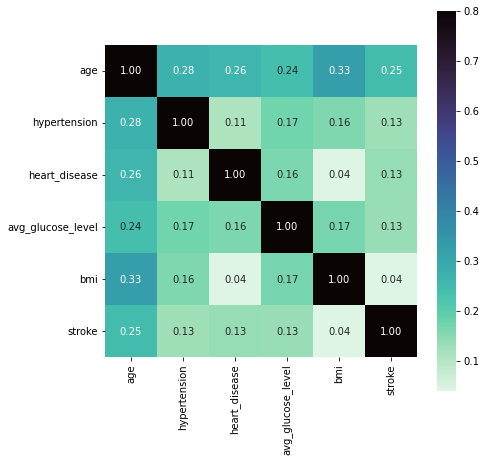

In [161]:
# Correlation of values with each other
correlation = df.corr()
fig, axes = plt.subplots(figsize=(7, 7))
sns.heatmap(correlation, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', cmap="mako_r", annot_kws={'size': 10});

### Let's split our features into two part, numerical and categorical, for easing our further examination.

In [56]:
numerical= df.drop(['stroke'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print("\033[1m", "Numerical Columns:", "\033[0;0m",  numerical)
print("------------------------------------------------------------------------------------------------------------------")
print("\033[1m", "Categorical Columns:", "\033[0;0m", categorical)

 Numerical Columns:  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')
------------------------------------------------------------------------------------------------------------------
 Categorical Columns:  Index(['gender', 'ever_married', 'work_type', 'residence_type',
       'smoking_status'],
      dtype='object')


### The Examination of Target Variable

In [57]:
df['stroke'].describe()

count    5109.000000
mean        0.048738
std         0.215340
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: stroke, dtype: float64

In [58]:
df['stroke'].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

In [59]:
print( f"Skewness: {df['stroke'].skew()}")

Skewness: 4.1928068074994735


0    4860
1     249
Name: stroke, dtype: int64

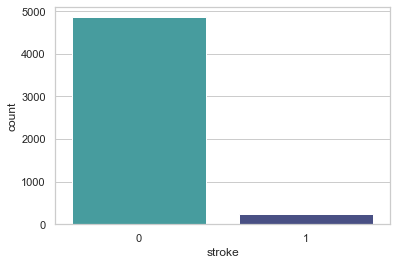

In [180]:
# Visualize stroke distribution
sns.countplot(x='stroke', data=df, palette="mako_r")
df.stroke.value_counts()

In [61]:
print("Stroke positive patient ratio: " + str(df.stroke.value_counts()[1]/len(df)))
print("Stroke negative patient ratio: " + str(df.stroke.value_counts()[0]/len(df)))

Stroke positive patient ratio: 0.04873752201996477
Stroke negative patient ratio: 0.9512624779800353


## Numerical Features

In [62]:
df_num=df[numerical].describe()
df_num

,age,hypertension,heart_disease,avg_glucose_level,bmi
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,43.229986,0.097475,0.054022,106.140399,28.894774
std,22.613660,0.296633,0.226084,45.285004,7.698235
min,0.000000,0.000000,0.000000,55.120000,10.300000
25%,25.000000,0.000000,0.000000,77.240000,23.800000
50%,45.000000,0.000000,0.000000,91.880000,28.400000
75%,61.000000,0.000000,0.000000,114.090000,32.800000
max,82.000000,1.000000,1.000000,271.740000,97.600000


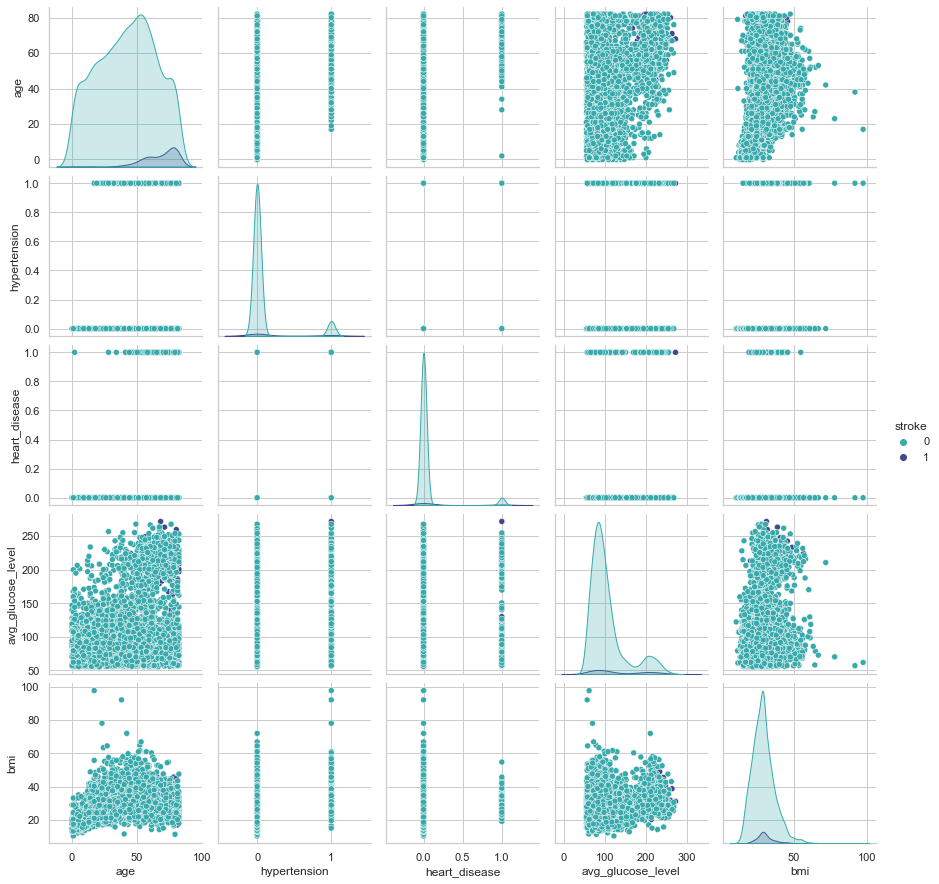

In [213]:
sns.pairplot(df, hue="stroke", palette="mako_r")

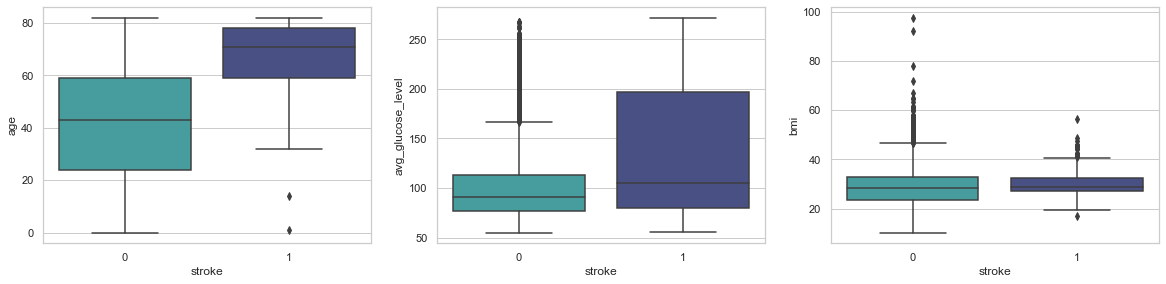

In [171]:
sns.set(style="whitegrid")
index = 0
plt.figure(figsize=(20,20))
for feature in df.drop(columns=['gender', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'smoking_status']).columns:
    if feature != "stroke":
        index += 1
        plt.subplot(4,3,index)
        
        sns.boxplot(x='stroke', y=feature, data=df, palette="mako_r")

In [65]:
## Examine the stroke patients' ages <=14 years old
df[(df['age'] <= 14) & (df['stroke'] == 1)] 

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,Female,1,0,0,No,children,Urban,70.37,28.9,Unknown,1
245,Female,14,0,0,No,children,Rural,57.93,30.9,Unknown,1


<AxesSubplot:xlabel='age', ylabel='avg_glucose_level'>

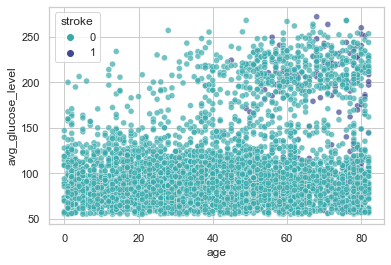

In [185]:
#Describe three variables
#scatter
sns.scatterplot(data=df, x='age', y='avg_glucose_level', hue='stroke', alpha=0.7, palette="mako_r")

## when we take in 3 variables ( age, avg_glucose_level , and stroke) it looks like most of people who have had stroke are on the right top side who are old and has a higher avg glucose level-- makes sense 

## ----------------------------------------------------------------------------------------

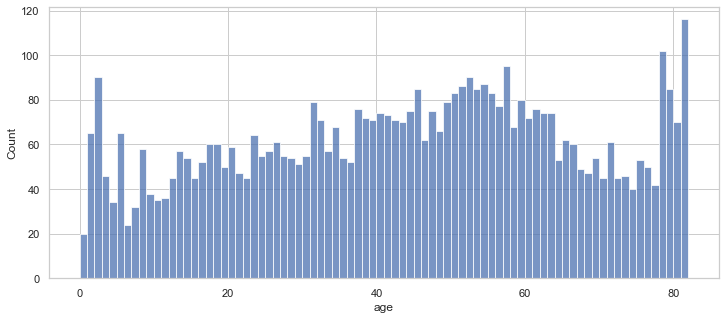

In [182]:
# Visualize age distribution
plt.figure(figsize=(12,5))
sns.histplot(df['age'], bins=max(df['age']), kde=False); #Age distribution of data is balanced.

## ----------------------------------------------------------------------------------------

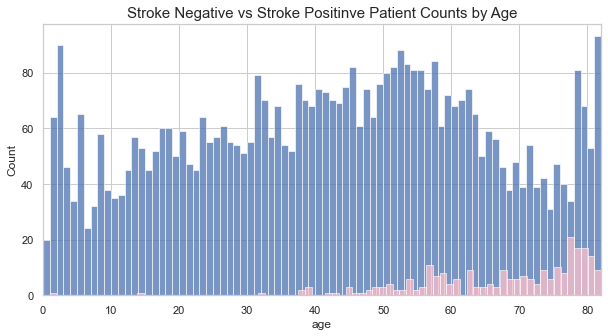

In [183]:
# Visualize age and stroke correlation.
plt.figure(figsize=(10, 5))

sns.histplot(df[df['stroke'] == 0]["age"], bins=max(df['age']), kde=False)
sns.histplot(df[df['stroke'] == 1]["age"], bins=max(df['age']), color='pink', kde=False)

plt.title('Stroke Negative vs Stroke Positinve Patient Counts by Age', fontsize=15)
plt.xlim([min(df['age']),max(df['age'])])
plt.show()

#According to above plot, we have balanced age distribution in stroke negative group.
#But stroke positive patients are stacked to the right.

## ----------------------------------------------------------------------------------------

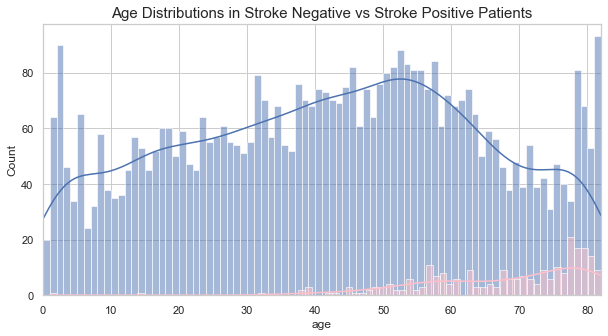

In [184]:
#Let's look age ratio distribution in each groups:
# Visualize age and stroke correlation
plt.figure(figsize=(10, 5))

sns.histplot(df[df['stroke'] == 0]["age"], bins=max(df['age']), kde=True)
sns.histplot(df[df['stroke'] == 1]["age"], bins=max(df['age']), color='pink', kde=True)

plt.title('Age Distributions in Stroke Negative vs Stroke Positive Patients', fontsize=15)
plt.xlim([min(df['age']),max(df['age'])])
plt.show()

# "Pic" saved - bmi - ave gluc level

### From the plots above, we can clearly see that age plays a huge role in predicting stroke. The normal BMI and Glucose Levels are in line with the values for positive cases. Alternatively, the positive cases tend to happen for ages 40+.

### This does not mean bmi and glucose levels don't play a role. They have an effect but its not clear yet.

## ----------------------------------------------------------------------------------------

## Categorical Features

In [70]:
df[categorical].head()

,gender,ever_married,work_type,residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked


In [71]:
def first_looking(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))

In [72]:
first_looking("gender")

column name    :  gender
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
Female    2994
Male      2115
Name: gender, dtype: int64


In [73]:
first_looking("ever_married")

column name    :  ever_married
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
Yes    3353
No     1756
Name: ever_married, dtype: int64


In [74]:
first_looking("work_type")

column name    :  work_type
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  5
Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


In [75]:
first_looking("smoking_status")

column name    :  smoking_status
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  4
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64


In [210]:

df[categorical].iplot(kind='hist', colors=['#1f77b4',
'#2ca02c',
'#e377c2',
'#7f7f7f',
'#17becf'])    #pic - catigorecal data iplot

## ----------------------------------------------------------------------------------------

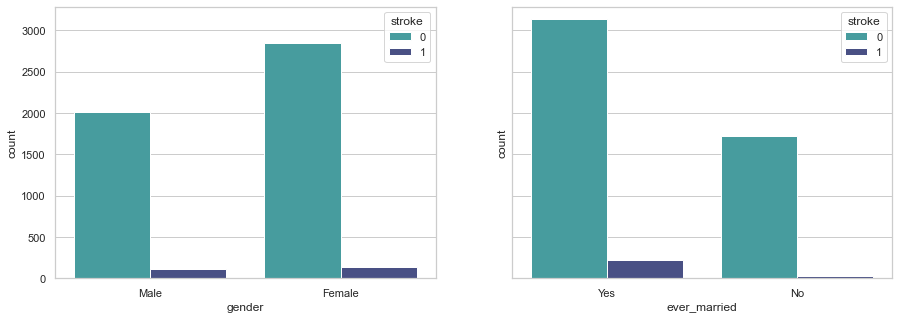

In [175]:
# Data distributions
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
## (gender vs stroke rate)
sns.countplot(x='gender', data=df, hue='stroke', ax=ax1, palette="mako_r");
## (marriage status vs stroke rate)
sns.countplot(x='ever_married', data=df, hue='stroke', ax=ax2, palette="mako_r");

fig.set_figwidth(15)
fig.set_figheight(5)

## The result with married people is kinda funny. The rate of stroke is higher in married people :) but this may be a result of bias :/
## we also could say that females have a little higher rate of stroke than male "but the contribution of females is more than males in this dataset". so this is not a certain result

## ----------------------------------------------------------------------------------------

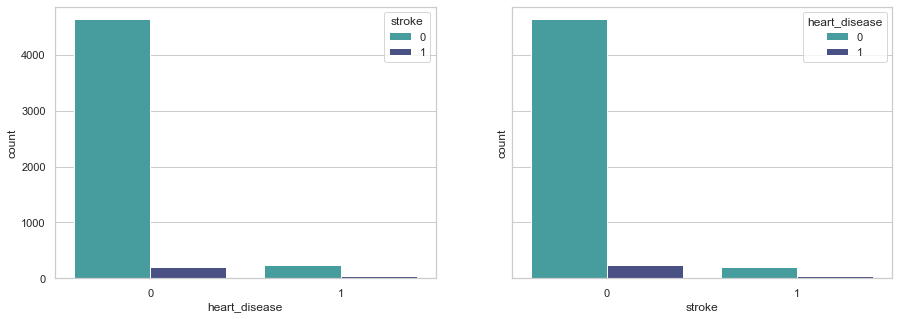

In [179]:
# deep look at the relation between having heart disease and the rate of stroke

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
### (heart disease vs  stroke rate)
sns.countplot(x='heart_disease', data=df, hue='stroke', ax=ax1, palette="mako_r")
sns.countplot(x='stroke', data=df, hue='heart_disease', ax=ax2, palette="mako_r")
fig.set_figwidth(15)
fig.set_figheight(5)

## Stroke and heart disesase surprisingly negative correlated.

## ----------------------------------------------------------------------------------------

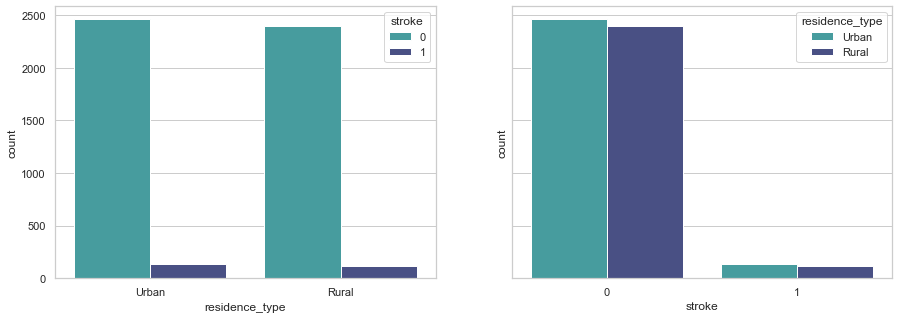

In [176]:
# relation between Residence_type and the rate of stroke


fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.countplot(x='residence_type', data=df, hue='stroke', ax=ax1, palette="mako_r")
sns.countplot(x='stroke', data=df, hue='residence_type', ax=ax2, palette="mako_r")
fig.set_figwidth(15)
fig.set_figheight(5)

## First plot shows that the numbers and rates of stroke and non-stroke patients are very similar in both localization types. The second plot also supports this.

## ----------------------------------------------------------------------------------------

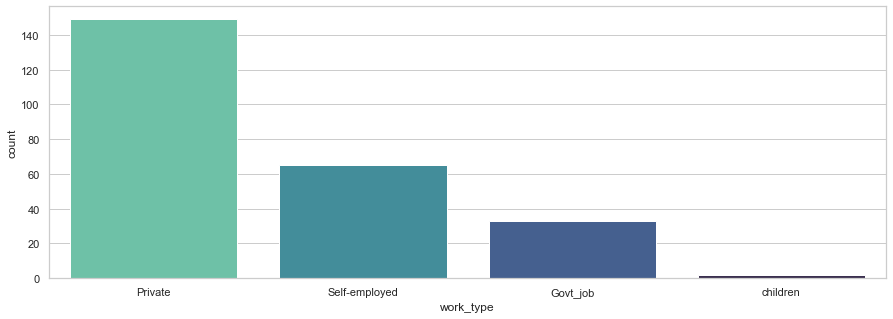

In [211]:
stroke_df = df[df["stroke"] == 1]
#Work type distribution in stroke patients
plt.figure(figsize=(15,5))
sns.countplot(data= stroke_df,x='work_type', palette="mako_r");

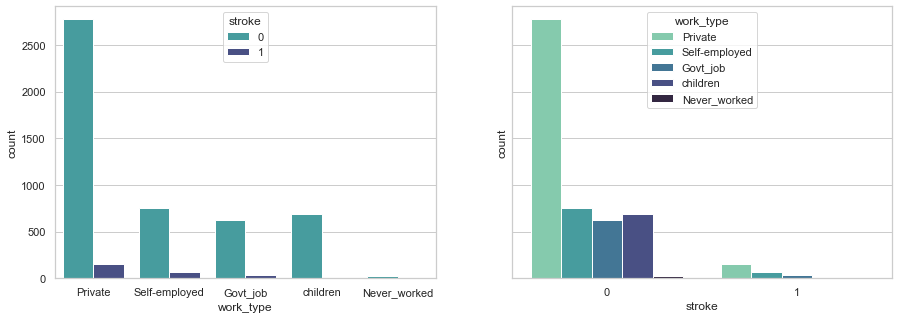

In [212]:
# Work type and stroke relationship
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.countplot(x='work_type', data=df, hue='stroke', ax=ax1, palette="mako_r")
sns.countplot(x='stroke', data=df, hue='work_type', ax=ax2, palette="mako_r")
fig.set_figwidth(15)
fig.set_figheight(5)

# I Believe there is nothing to be indicated for sure from these charts because the majority of the dataset has a privet work so having the highest rate in this sector is logical

## ----------------------------------------------------------------------------------------

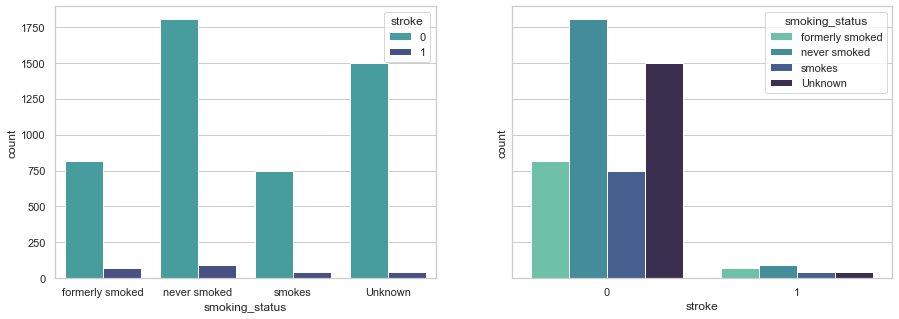

In [177]:
# Smoking status and stroke relationship

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.countplot(x='smoking_status', data=df, hue='stroke', ax=ax1, palette="mako_r")
sns.countplot(x='stroke', data=df, hue='smoking_status', ax=ax2, palette="mako_r")
fig.set_figwidth(15)
fig.set_figheight(5)

In [83]:
stroke_df = df[df["stroke"] == 1]

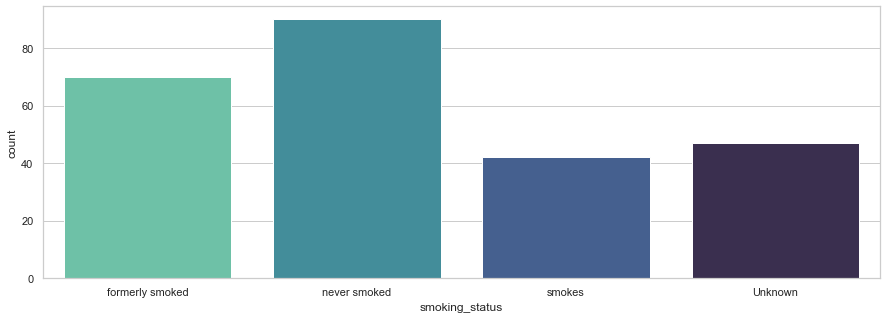

In [178]:
#Smoking status distribution in stroke patients
plt.figure(figsize=(15,5))
sns.countplot(data=stroke_df,x='smoking_status', palette="mako_r");

## According to data of smokers, most common pattern in stroke group is non-smokers. Strange but true. This may be due to other factors affecting stroke and a biased assesment.

## ----------------------------------------------------------------------------------------


## ----------------------------------------------------------------------------------------

## ----------------------------------------------------------------------------------------

# Data Preprocessing for preperation for modeling


In [85]:
df.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.9,never smoked,1
2,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [86]:
# hot encoding  "Gitting dummies" 'work_type', 'smoking_status' columns
df = pd.get_dummies(df, columns=["work_type", "smoking_status"], prefix=["work_type", "smoking_status"])

# Convert 'gender' boolean 1 male --- 0 female
df["gender"] = df["gender"].apply(lambda x: 1 if x=="Male" else 0)

# Convert 'ever_married' boolean  married 1  -- 0 not married
df["ever_married"] = df["ever_married"].apply(lambda x: 1 if x=="Yes" else 0)

# Encode "Residence_type" boolean  urban 1  --- suburb 0
df["residence_type"] = df["residence_type"].apply(lambda x: 1 if x=="Urban" else 0)

In [87]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67,0,1,1,1,228.69,36.6,1,0,0,1,0,0,0,1,0,0
1,0,61,0,0,1,0,202.21,28.9,1,0,0,0,1,0,0,0,1,0
2,1,80,0,1,1,0,105.92,32.5,1,0,0,1,0,0,0,0,1,0
3,0,49,0,0,1,1,171.23,34.4,1,0,0,1,0,0,0,0,0,1
4,0,79,1,0,1,0,174.12,24.0,1,0,0,0,1,0,0,0,1,0


In [88]:
# Scaling the variance in features

std=StandardScaler()

columns = ['age','avg_glucose_level','bmi']
scaled = std.fit_transform(df[['age','avg_glucose_level','bmi']])
scaled = pd.DataFrame(scaled, columns=columns, index= df.index.values)

df2=df.drop(columns=columns,axis=1)
df2=df2.merge(scaled, left_index=True, right_index=True, how = "left")
df2

,gender,hypertension,heart_disease,ever_married,residence_type,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,avg_glucose_level,bmi
0,1,0,1,1,1,1,0,0,1,0,0,0,1,0,0,1.051238,2.706450,1.001006
1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0.785886,2.121652,0.000679
2,1,0,1,1,0,1,0,0,1,0,0,0,0,1,0,1.626168,-0.004867,0.468364
3,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0.255181,1.437473,0.715198
4,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1.581943,1.501297,-0.635893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,1.626168,-0.494481,0.000679
5106,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1.670394,0.420922,1.442709
5107,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,-0.363974,-0.511266,0.221530
5108,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0.343632,1.328375,-0.428033


# splitting data into test and train

In [89]:
X = df.loc[:, df.columns != 'stroke']
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# resampling by SMOTE
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [90]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## ----------------------------------------------------------------------------------------

## Building Models

### Adaboost Classification

Train score of AdaBoostClassifier is 0.9410256410256409 %
*************
Precision score is  0.13829787234042554
*************
ROC Score is 0.5626512096774193
*************
Recall Score is  0.20967741935483872
*************************************************
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       960
           1       0.14      0.21      0.17        62

    accuracy                           0.87      1022
   macro avg       0.54      0.56      0.55      1022
weighted avg       0.90      0.87      0.88      1022



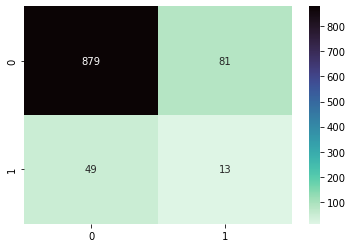

In [139]:
from sklearn.ensemble import AdaBoostClassifier

#create obj
ab_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, 
                            learning_rate=0.5, random_state=100)

#training
ab_clf.fit(X_train, y_train)

# prediction using the test set
y_pred= ab_clf.predict(X_test)

#score
ab_clf_score = ab_clf.score(X_test, y_test)


score = cross_val_score(ab_clf, X_train, y_train, cv = 6)
precision = precision_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print ('Train score of AdaBoostClassifier is', score.mean(),'%')
print ('*************')
print ('Precision score is ', precision)
print ('*************')
print ('ROC Score is', roc)
print ('*************')
print ('Recall Score is ', recall)
print ('*************************************************')
sns.heatmap(cm, annot=True,fmt='d',cmap="mako_r");

print(classification_report(y_test,y_pred))

## ----------------------------------------------------------------------------------------

## XGboost

Train score of XGboost is 0.9410256410256409 %
*************
Precision score is  0.13829787234042554
*************
ROC Score is 0.5626512096774193
*************
Recall Score is  0.20967741935483872
*************************************************
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       960
           1       0.18      0.29      0.22        62

    accuracy                           0.88      1022
   macro avg       0.57      0.60      0.58      1022
weighted avg       0.91      0.88      0.89      1022



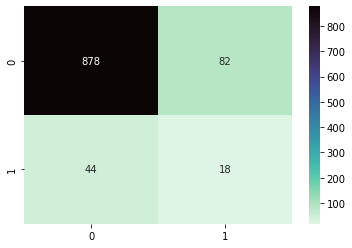

In [140]:
from sklearn.ensemble import GradientBoostingClassifier

#create obj
xgboost_clf = GradientBoostingClassifier(random_state=0)

#training
xgboost_clf.fit(X_train, y_train)

# prediction using the test set
y_pred= xgboost_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print ('Train score of XGboost is', score.mean(),'%')
print ('*************')
print ('Precision score is ', precision)
print ('*************')
print ('ROC Score is', roc)
print ('*************')
print ('Recall Score is ', recall)
print ('*************************************************')

sns.heatmap(cm, annot=True,fmt='d',cmap="mako_r");

print(classification_report(y_test,y_pred))

## ----------------------------------------------------------------------------------------

# Random Forest Classifier

Train score of RandomForest is 0.9410256410256409 %
*************
Precision score is  0.13829787234042554
*************
ROC Score is 0.5626512096774193
*************
Recall Score is  0.20967741935483872
*************************************************
              precision    recall  f1-score   support

           0       0.96      0.81      0.87       960
           1       0.12      0.42      0.19        62

    accuracy                           0.78      1022
   macro avg       0.54      0.61      0.53      1022
weighted avg       0.91      0.78      0.83      1022



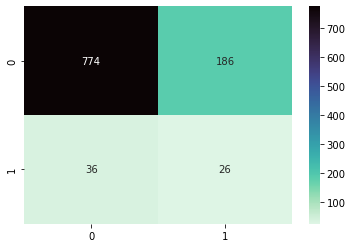

In [141]:
#create RandomForest classification obj
forest_obj = RandomForestClassifier()
parameters = {'n_estimators':[10, 20, 50, 100], 'max_depth':[2, 4, 6]}
forest = GridSearchCV(forest_obj, parameters)

#training via RandomForest classficiation model
forest.fit(X_train, y_train)

#make prediction using the test set
y_pred= forest.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print ('Train score of RandomForest is', score.mean(),'%')
print ('*************')
print ('Precision score is ', precision)
print ('*************')
print ('ROC Score is', roc)
print ('*************')
print ('Recall Score is ', recall)
print ('*************************************************')

sns.heatmap(cm, annot=True,fmt='d',cmap="mako_r");

print(classification_report(y_test,y_pred))

## ----------------------------------------------------------------------------------------

# Logistic Regression

Train score of Logistic Regression is 0.9410256410256409 %
*************
Precision score is  0.13829787234042554
*************
ROC Score is 0.5626512096774193
*************
Recall Score is  0.20967741935483872
*************************************************
              precision    recall  f1-score   support

           0       1.00      0.07      0.13       960
           1       0.06      1.00      0.12        62

    accuracy                           0.13      1022
   macro avg       0.53      0.53      0.13      1022
weighted avg       0.94      0.13      0.13      1022



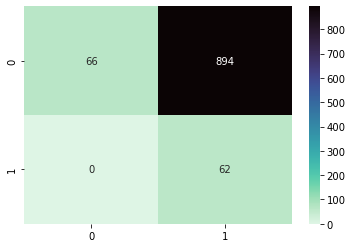

In [142]:
#create obj
regression = LogisticRegression()

#training
regression.fit(X_train, y_train)

# prediction using the test set
y_pred= regression.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print ('Train score of Logistic Regression is', score.mean(),'%')
print ('*************')
print ('Precision score is ', precision)
print ('*************')
print ('ROC Score is', roc)
print ('*************')
print ('Recall Score is ', recall)
print ('*************************************************')

sns.heatmap(cm, annot=True,fmt='d',cmap="mako_r");

print(classification_report(y_test,y_pred))

## ----------------------------------------------------------------------------------------

## XGBoost gives the best results with 0.88 accuracy and 0.91 recall 


## ----------------------------------------------------------------------------------------

## ----------------------------------------------------------------------------------------